<a href="https://colab.research.google.com/github/FedorTaggenbrock/data_intensive_systems/blob/main/notebooks/main_tests_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Handle importing/installing, both local and on Colab**

In [3]:
import sys
global ON_COLAB
ON_COLAB = 'google.colab' in sys.modules
if ON_COLAB:
    # Do stuff that only needs to happen on colab
    !pip install pyspark  # noqa
    !pip install ijson
    pass
else:
    # Do stuff that only needs to happen on local computer
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Rerun the code cell below to use the latest version of the python files!

In [8]:
import importlib

def import_modules():
    if ON_COLAB:
        print("Running in Colab: importing from GitHub.")
        # Clone the repository
        !git clone https://github.com/FedorTaggenbrock/data_intensive_systems.git

        # Change the current working directory to the cloned repository directory
        %cd /content/data_intensive_systems

        # Pull the latest changes from the repository
        !git pull origin main

        # Change back to the original working directory
        %cd /content

        # Add the path of the modules to sys.path
        sys.path.insert(0, "/content/data_intensive_systems/src")
    else:
        print("Running locally, importing from local.")
        # Append parent folder to path
        sys.path.append('../src')

    # Import and reload modules iteratively
    module_names = ['clustering',
                    'data_visualization',
                    'distance_functions',
                    'evaluate_clustering',
                    'generate_data',
                    'main_tests',
                    'plot_clustering',
                    # 'non_spark_function_debugger',
                    'parse_data',
                    # 'parse_data_2',
                    # 'parse_data_3',
                    'abe_tests',
                    ]
    for module_name in module_names:
        print(module_name)

        module = importlib.import_module(module_name)
        importlib.reload(module)
        globals()[module_name] = module

import_modules()


Running in Colab: importing from GitHub.
fatal: destination path 'data_intensive_systems' already exists and is not an empty directory.
/content/data_intensive_systems
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 326 bytes | 326.00 KiB/s, done.
From https://github.com/FedorTaggenbrock/data_intensive_systems
 * branch            main       -> FETCH_HEAD
   9feccee..38092e0  main       -> origin/main
Updating 9feccee..38092e0
Fast-forward
 src/plot_clustering.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
/content
clustering
data_visualization
distance_functions
evaluate_clustering
generate_data
main_tests
plot_clustering
parse_data
abe_tests


In [ ]:
main_tests.run_all_tests()

-------

In [ ]:
abe_tests.__run_all_tests()

In [10]:
# General modules
import numpy as np
import scipy.spatial.distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pickle
import sys
import os

# Spark etc
from pyspark import RDD
from pyspark.sql import SparkSession

# Typing
from typing import Any, Callable, Union


from pyspark.sql import SparkSession
import pandas as pd

# Own stuff

# from data_visualization import plot_routes, convert_pd_df_to_one_row
from plot_clustering import plot_metrics, plot_confusion_matrix2
from clustering import run_clustering, run_final_clustering, route_distance
from parse_data import get_nested_data, get_vector_dataframe, get_data
from evaluate_clustering import evaluate_clustering, get_best_setting

def save_results_test(results, clustering_settings):
    os.makedirs('data/serialized_results_for_debugging/', exist_ok=True)
    # Make the name of the file
    algo = clustering_settings['clustering_algorithm']
    kvals = '[' + '-'.join( [str(kval) for kval in clustering_settings['k_values']] ) + ']'
    iters = clustering_settings['max_iterations']
    name = f"algo={algo}_kvalues={kvals}_maxiter={iters}"

    with open('data/serialized_results_for_debugging/results__{}__.pkl'.format(name), 'wb') as f:
        pickle.dump(results, f)

def load_results(path=r'data\serialized_results_for_debugging\results__algo=kmodes_kvalues=[3]_max_iter=4.pkl'):
    with open(path, 'rb') as f:
        return pickle.load(f)

clustering_settings = {
        'clustering_algorithm': 'kmeans',
        'k_values': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        'distance_function': route_distance,
        'max_iterations': 4,
        'debug_flag': False,
    }

spark = None
spark = SparkSession.builder.appName("Clustering").getOrCreate()


print("Loading data")

_ON_COLAB = 'google.colab' in sys.modules
if clustering_settings['debug_flag']: print('On colab: ', _ON_COLAB)
general_data_path = r'\data\data_12_06\1000_0.25_actual_routes.json'
general_perfect_centroids_path = r'\data\data_12_06\10_standard_route.json'
try:
    if _ON_COLAB:
        data_path = '/content/data_intensive_systems' + general_data_path.replace("\\", "/")
        perfect_centroid_path = '/content/data_intensive_systems/data/data_12_06/10_standard_route.json'
    else:
        data_path = os.getcwd() + general_data_path
        perfect_centroid_path = os.getcwd() + general_perfect_centroids_path
except Exception as e:
    print('Data path was not found.\n\n', e)
    data_path = None
    perfect_centroid_path = None

# Load datafile
if clustering_settings['clustering_algorithm'] == 'kmodes':
    data = get_nested_data(spark, data_path, clustering_settings)
    perfect_centroids = get_nested_data(spark, perfect_centroid_path, clustering_settings)
elif clustering_settings['clustering_algorithm'] == 'kmeans':
    data, indices2from_to_prods = get_vector_dataframe(spark, data_path, clustering_settings["debug_flag"])
    perfect_centroids = get_vector_dataframe(spark, perfect_centroid_path, clustering_settings["debug_flag"])
else:
    data = None
    perfect_centroids = None

# Run the clustering algorithm
print("Running run_clustering().")
results_and_metrics = run_clustering(
    data=data,
    clustering_settings=clustering_settings
)

# Save the results (optional, Abe)
save_results_test(results_and_metrics, clustering_settings)

# Evaluate the clustering
results = results_and_metrics[0]
metrics = results_and_metrics[1]

if not metrics: # if kmodes, then metrics not yet calculated
    print("Start evaluating clusters")
    metrics = evaluate_clustering(
        data=data,
        clustering_result=results_and_metrics,
        clustering_settings=clustering_settings
    )



Loading data
Running run_clustering().
Performing clustering with k=4
Performing clustering with k=5
Performing clustering with k=6
Performing clustering with k=7
Performing clustering with k=8
Performing clustering with k=9
Performing clustering with k=10
Performing clustering with k=11
Performing clustering with k=12
Performing clustering with k=13


In [71]:
data.collect()[0]

Row(id-sr='0 0', features=SparseVector(3120, {118: 12.0, 228: 14.0, 299: 14.0, 443: 18.0, 455: 16.0, 605: 8.0, 673: 5.0, 720: 7.0, 783: 3.0, 960: 13.0, 970: 12.0, 1033: 11.0, 1158: 11.0, 1253: 10.0, 1331: 8.0, 1469: 8.0, 1498: 4.0, 1590: 3.0, 1923: 8.0, 1962: 9.0, 2014: 18.0, 2015: 9.0, 2129: 12.0, 2305: 19.0, 2314: 13.0, 2371: 6.0, 2491: 10.0, 2627: 12.0, 2719: 13.0, 2733: 18.0, 2769: 11.0, 2926: 14.0, 2934: 19.0, 3056: 8.0, 3091: 4.0}))


Best settings are given by: 
 {'k': 12}


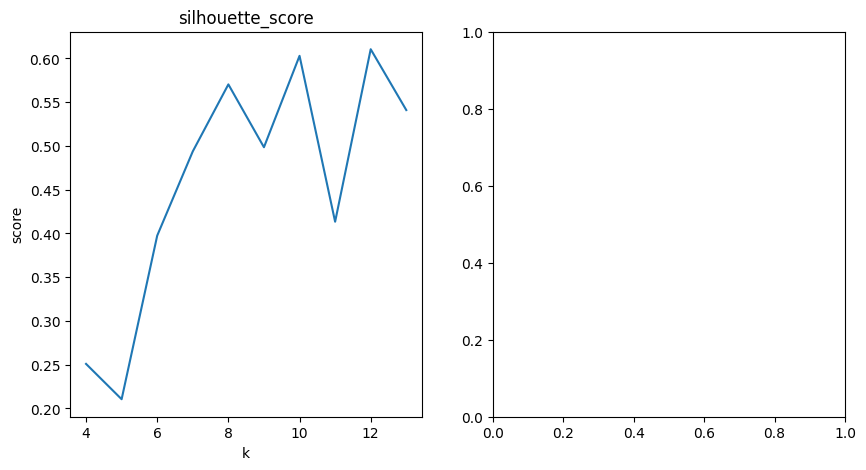

In [11]:
best_settings = get_best_setting(metrics)
print("\nBest settings are given by: \n", best_settings)

# Generate plots
metric_plot = plot_metrics(metrics, clustering_settings)
metric_plot.show()

In [56]:
import numpy as np
import math
from collections import Counter
import random
import os
from copy import copy
from statistics import mode

from functools import reduce
import numpy as np
import math
from copy import copy
from statistics import mode

# Spark
from pyspark import RDD
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark import RDD
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from functools import reduce


from pyspark.sql import DataFrame

# kmeans
from pyspark.ml.clustering import KMeans

# Evaluation





def run_clustering(data, clustering_settings: dict, perfect_centroids=None) -> tuple[list, list]:
    '''Define variables to store results.'''
    # E.g. for kmodes:  ( results                                , metrics                                      )
    # E.g. for kmodes:  ( [(predicted_centroids, (k, init_mode))], []                                           )
    #           kmeans: ( [(predicted_centroids, (k, init_mode))], [ {'silhoutte_score': 0.6}, (k, init_mode) ] )
    results = []
    metrics = []

    # Check which clustering algortihm to run
    if clustering_settings['clustering_algorithm'] == 'kmodes':
        for current_k in clustering_settings['k_values']:
            # TODO in the future add other parameters here.
            # Run clustering with current parameters
            print("Performing clustering with k= ", current_k)
            predicted_centroids = kModes(
                data=data,
                k=current_k,
                clustering_settings=clustering_settings
            )

            # Store the settings, model, and metrics
            results.append((predicted_centroids, {'k': current_k}))
            if clustering_settings["debug_flag"]:
                print(f"The centroids for k = {current_k} are given by: {[c[0] for c in predicted_centroids]}")
    elif clustering_settings['clustering_algorithm'] == 'kmeans':
        for current_k in clustering_settings['k_values']:
            print(f"Performing clustering with k={current_k}")
            clustered_data, predicted_centroids = kMeans(
                data=data,
                k=current_k,
                clustering_settings=clustering_settings
            )

            # Evualate the clustering
            curr_metric = evaluate_kMeans(
                clustered_data=clustered_data,
                predicted_centroids=predicted_centroids,
                perfect_centroids=perfect_centroids,
                clustering_settings=clustering_settings
            )
            # Also store current k
            curr_metric['settings'] = {'k':current_k}

            # Store the settings, model, and metrics
            results.append((predicted_centroids, {'k': current_k}))
            metrics.append(curr_metric)

            if clustering_settings["debug_flag"]:
                print("The centroids for  k = ", current_k, " are given by:\n")
                # for c in predicted_centroids: print(c)
                pass

    else:
        print("Clustering algorithm setting not recognized in run_and_tune().")

    if clustering_settings["debug_flag"]:
        print("The output results for multiple k is given by:", results)
    return (results, metrics)

def run_final_clustering(data, best_setting: dict, clustering_settings: dict, perfect_centroids=None) -> tuple[DataFrame, list, dict]:
    """To be ran after tuning, will be very similar to the run_clustering, but the best_setting can be used."""

    clustered_data = None
    predicted_centroids = None
    curr_metric = None

    # Check which clustering algortihm to run
    if clustering_settings['clustering_algorithm'] == 'kmodes':
        print(f"Running final clustering with k={best_setting['k']}")
        clustered_data, predicted_centroids = kModes(
            data=data,
            k=best_setting['k'],
            clustering_settings=clustering_settings
        )

        curr_metric = evaluate_kMeans(
            clustered_data=clustered_data,
            predicted_centroids=predicted_centroids,
            perfect_centroids=perfect_centroids,
            clustering_settings=clustering_settings
        )
        raise NotImplementedError("kmodes not implemented yet")

    else: # clustering_settings['clustering_algorithm'] == 'kmeans':
        # Cluster and evaluate
        print(f"Running final clustering with k={best_setting['k']}")
        clustered_data, predicted_centroids = kMeans(
            data=data,
            k=best_setting['k'],
            clustering_settings=clustering_settings
        )

        curr_metric = evaluate_kMeans(
            clustered_data=clustered_data,
            predicted_centroids=predicted_centroids,
            perfect_centroids=perfect_centroids,
            clustering_settings=clustering_settings
        )

    return (clustered_data, predicted_centroids, curr_metric)

def kMeans(data: DataFrame, k: int, clustering_settings: dict) -> tuple[DataFrame, list]:
    # Creating the K-means instance
    kmeans = KMeans(k=k)

    # Fitting the model
    model = kmeans.fit(data.select('features'))

    # Getting the cluster predictions
    clustered_data = model.transform(data)

    if clustering_settings["debug_flag"]:
        print("clustered_df structure:")
        clustered_data.show(2)

    return clustered_data, model.clusterCenters()



In [76]:
# General modules
import numpy as np
import scipy.spatial.distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pandas as pd

# Spark etc
from pyspark import RDD
from pyspark.sql import SparkSession

# Typing
from typing import Any, Union

# Own stuff

# kmeans
from pyspark.ml.evaluation import ClusteringEvaluator




def run_clustering(data, clustering_settings: dict, perfect_centroids=None) -> tuple[list, list]:
    '''Define variables to store results.'''
    # E.g. for kmodes:  ( results                                , metrics                                      )
    # E.g. for kmodes:  ( [(predicted_centroids, (k, init_mode))], []                                           )
    #           kmeans: ( [(predicted_centroids, (k, init_mode))], [ {'silhoutte_score': 0.6}, (k, init_mode) ] )
    results = []
    metrics = []

    # Check which clustering algortihm to run
    if clustering_settings['clustering_algorithm'] == 'kmodes':
        for current_k in clustering_settings['k_values']:
            # TODO in the future add other parameters here.
            # Run clustering with current parameters
            print("Performing clustering with k= ", current_k)
            predicted_centroids = kModes(
                data=data,
                k=current_k,
                clustering_settings=clustering_settings
            )

            # Store the settings, model, and metrics
            results.append((predicted_centroids, {'k': current_k}))
            if clustering_settings["debug_flag"]:
                print(f"The centroids for k = {current_k} are given by: {[c[0] for c in predicted_centroids]}")
    elif clustering_settings['clustering_algorithm'] == 'kmeans':
        for current_k in clustering_settings['k_values']:
            print(f"Performing clustering with k={current_k}")
            clustered_data, predicted_centroids = kMeans(
                data=data,
                k=current_k,
                clustering_settings=clustering_settings
            )

            # Evualate the clustering
            curr_metric = evaluate_kMeans(
                clustered_data=clustered_data,
                predicted_centroids=predicted_centroids,
                perfect_centroids=perfect_centroids,
                clustering_settings=clustering_settings
            )
            # Also store current k
            curr_metric['settings'] = {'k':current_k}

            # Store the settings, model, and metrics
            results.append((predicted_centroids, {'k': current_k}))
            metrics.append(curr_metric)

            if clustering_settings["debug_flag"]:
                print("The centroids for  k = ", current_k, " are given by:\n")
                # for c in predicted_centroids: print(c)
                pass

    else:
        print("Clustering algorithm setting not recognized in run_and_tune().")

    if clustering_settings["debug_flag"]:
        print("The output results for multiple k is given by:", results)
    return (results, metrics)

def run_final_clustering(data, best_setting: dict, clustering_settings: dict, perfect_centroids=None) -> tuple[DataFrame, list, dict]:
    """To be ran after tuning, will be very similar to the run_clustering, but the best_setting can be used."""

    clustered_data = None
    predicted_centroids = None
    curr_metric = None

    # Check which clustering algortihm to run
    if clustering_settings['clustering_algorithm'] == 'kmodes':
        print(f"Running final clustering with k={best_setting['k']}")
        clustered_data, predicted_centroids = kModes(
            data=data,
            k=best_setting['k'],
            clustering_settings=clustering_settings
        )

        curr_metric = evaluate_kMeans(
            clustered_data=clustered_data,
            predicted_centroids=predicted_centroids,
            perfect_centroids=perfect_centroids,
            clustering_settings=clustering_settings
        )
        raise NotImplementedError("kmodes not implemented yet")

    else: # clustering_settings['clustering_algorithm'] == 'kmeans':
        # Cluster and evaluate
        print(f"Running final clustering with k={best_setting['k']}")
        clustered_data, predicted_centroids = kMeans(
            data=data,
            k=best_setting['k'],
            clustering_settings=clustering_settings
        )

        curr_metric = evaluate_kMeans(
            clustered_data=clustered_data,
            predicted_centroids=predicted_centroids,
            perfect_centroids=perfect_centroids,
            clustering_settings=clustering_settings
        )

    return (clustered_data, predicted_centroids, curr_metric)


def kMeans(data: DataFrame, k: int, clustering_settings: dict) -> tuple[DataFrame, list]:
    # Creating the K-means instance
    kmeans = KMeans(k=k)

    # Fitting the model
    model = kmeans.fit(data.select('features'))

    # Getting the cluster predictions
    clustered_data = model.transform(data)

    if clustering_settings["debug_flag"]:
        print("clustered_df structure:")
        clustered_data.show(2)

    return clustered_data, model.clusterCenters()


from pyspark.sql.types import FloatType
from scipy.spatial import distance
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, mean

import pyspark.sql.functions as F
from pyspark.sql.functions import pandas_udf
from pyspark.sql.pandas.functions import PandasUDFType

@pandas_udf("float")
def euclidean_distance_pandas(features: pd.Series, prediction: pd.Series) -> pd.Series:
    # Convert features to appropriate format
    features = features.apply(lambda x: x.toArray().tolist() if hasattr(x, "toArray") else x)
    # Use numpy array for efficient computations
    features = pd.Series(list(features)).apply(np.array)
    # Calculate euclidean distance
    distances = features.apply(lambda x: distance.euclidean(x, predicted_centroids[prediction]))
    return distances

def evaluate_kMeans(clustered_data, predicted_centroids, clustering_settings: dict, perfect_centroids=None) -> dict:
    # Store the results etc
    metrics = {}
    debug1=True
    if debug1: print('calculating distance')

    # Use the Pandas UDF to add a 'distance' column
    clustered_data = clustered_data.withColumn('distance', euclidean_distance_pandas(clustered_data['features'], clustered_data['prediction']))
    # Calculate the metrics

    if debug1: print('aggregating metrics')
    # Initialize the evaluator
    evaluator = ClusteringEvaluator()
    metrics['silhouette_score'] = evaluator.evaluate(clustered_data)

    # Calculate the average sum-of-squared distance to each cluster center
    metrics['avg_sum_of_squared_distance'] = clustered_data.agg(F.mean('distance')).first()[0]

    return metrics



In [77]:
# Get final results
clustered_data, predicted_centroids, metric = run_final_clustering(
    data=data,
    clustering_settings=clustering_settings,
    best_setting=best_settings,
)

Running final clustering with k=12
calculating distance
aggregating metrics


PythonException: ignored

In [55]:
a = type(predicted_centroids[0])
b = type(clustered_data)

print(a)
print(b)

<class 'numpy.ndarray'>
<class 'pyspark.sql.dataframe.DataFrame'>


In [47]:
import seaborn as sns
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

def get_confusion_matrix(clustered_df):
    # Generate a table which has the standard routes as rows and the cluster centres as columns. It shows for each found cluster center,
    #  which route it belongs to; this is because the datapoints in each cluster are grouped per standard-route-id.
    grouped_df = clustered_df.withColumn("sr\predicted_clusters", col("id-sr").substr(-1, 1)) \
    .groupBy("sr\\predicted_clusters") \
    .pivot("prediction") \
    .agg(count("*").alias("count"))

    return grouped_df



def get_aligned_df(grouped_df_pd):
    debug1=False
    debug2=False

    # Store the original column order
    old_columns = grouped_df_pd.columns
    if debug2: print('old_columns: ',old_columns)

    '''Hungarian algorithm to line up large values on the diagonal'''
    # Perform the Hungarian algorithm to solve the assignment problem
    _, col_ind = linear_sum_assignment(-grouped_df_pd.values)  # We multiply by -1 to find the maximum assignment
    col_names = grouped_df_pd.columns[col_ind]
    reordered_df = grouped_df_pd[col_names]
    '''End Hungarian algorithm'''

    # Identify the remaining columns and add those back
    remaining_columns = [col for col in old_columns if col not in col_names]
    reordered_df = pd.concat([reordered_df, grouped_df_pd[remaining_columns]], axis=1)

    if debug2: print('col_names: ',col_names)
    if debug1: print('reordered_df:', reordered_df.head(), '\n')



    # Make a mapping from the old clusters to the new clusters
    old_to_new_cluster_index_map = {old:new for old,new in zip(old_columns, reordered_df.columns)}
    if debug2: print(old_to_new_cluster_index_map)

    # Reset the column-names (so the names of predicted clusters) to start from 0
    col_mapping = {col: i for i, col in enumerate(reordered_df.columns)}
    reordered_df.columns = [col_mapping.get(col, len(reordered_df.columns)) for col in reordered_df.columns]



    return reordered_df, old_to_new_cluster_index_map

def plot_confusion_matrix2(clustered_df):
    debug1=False
    debug2=False

    # Get the data from the dataframe into pandas format
    grouped_df = get_confusion_matrix(clustered_df)
    if debug1: print('grouped_df:\n', grouped_df, '\n')

    grouped_df_pd = grouped_df.toPandas()
    if debug1: print('grouped_df:\n', grouped_df_pd.head(), '\n')

    grouped_df_pd = grouped_df_pd.set_index('sr\\predicted_clusters').fillna(0)
    if debug1: print('grouped_df:\n', grouped_df_pd.head(), '\n')

    # Sort DataFrame rows by index of standard routes (so that they go from 0 to ...)
    grouped_df_pd = grouped_df_pd.sort_index(ascending=True)

    # Reorder the columns
    reordered_df, old_to_new_cluster_index_map = get_aligned_df(grouped_df_pd)
    if debug2: print(old_to_new_cluster_index_map)


    # Calculate the ideal datapoints per cluster
    total_datapoints = reordered_df.sum().sum()
    ideal_datapoints_per_cluster = total_datapoints / len(reordered_df.index)

    # Normalize each column by its sum or ideal_datapoints_per_cluster, whichever is greater
    column_sums = reordered_df.sum(axis=0)
    normalizing_values = column_sums.where(column_sums > ideal_datapoints_per_cluster, ideal_datapoints_per_cluster)
    normalized_per_column_df = reordered_df.div(normalizing_values, axis=1)

    final_df = normalized_per_column_df


    # Now visualize the normalized dataframe. But, use the original values for the annotations.
    fig, ax = plt.subplots(figsize=(10, 10))
    annotation_df = reordered_df.astype(int)

    sns.heatmap(final_df,
                annot=annotation_df, # Comment out if you want the normalized value per predicted cluster center
                # annot=True, # Uncomment if you do the above
                fmt='g', cmap='Blues', ax=ax
    )

    # Change x-ticks to top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    ax.set_xlabel('Cluster Center ID')
    ax.set_ylabel('Standard Route ID')
    ax.set_title('Confusion Matrix')

    # Adjust the position of the title.
    ax.title.set_position([.5, 1.05])

    return fig





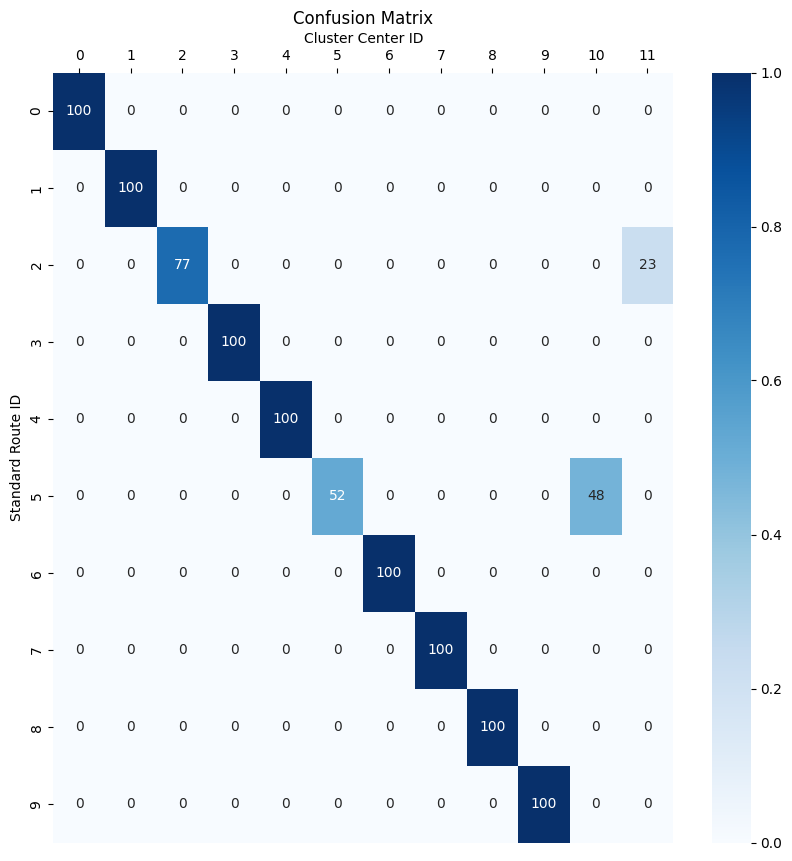

In [48]:
# Show confusion matrix
confusion_plot = plot_confusion_matrix2(clustered_data) #  indices2from_to_prods)

Test all functions you want inside the run_all_tests() during development, for small sample sizes.


Code below is for actual result generation later, so that we can easily reuse intermediate values.

**Create a spark instance**

In [ ]:
spark_settings = {}
spark_instance = make_spark()

NameError: ignored

**Load and parse data**

In [ ]:
# Load and parse data
data_for_spark = parse_data()

**Perform clustering**

In [ ]:
# Run clustering and parameter tuning
clustering_settings = {
    'clustering_algorithm':'kmodes',
}
clustering_centroid_outcomes = run_clustering(
    spark_instance=spark_instance,
    data_for_spark, clustering_settings)

In [ ]:
# Evaluate clustering results
clustering_evaluation = evaluate_clustering(clustering_centroid_outcomes)

**Display results**

In [ ]:
# Display results (maybe only best result)
clustering_result = display_results(clustering_evaluation